In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42) # Results might change because I have added this as the last line of code in this notebook


%matplotlib inline

In [2]:
df = pd.read_csv('./homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [4]:
df.shape

(8188, 4)

In [9]:
len(df.id.unique())

6328

In [10]:
df[df['group']=='experiment'].shape

(3924, 4)

In [20]:
df[df['group']=='control'].shape

(4264, 4)

## About how long was this experiment run for?

In [59]:
from dateutil.parser import parse
date = parse('2016-09-24')

print(date.year)
print(date.month)
print(date.day)

2016
9
24


In [34]:
dates = df.timestamp.apply(parse)

In [56]:
print(max(dates))
print(min(dates))

2017-01-18 10:24:08.629327
2016-09-24 17:42:27.839496


In [58]:
latest, oldest = max(dates), min(dates)

interval = latest - oldest

print(interval)

115 days 16:41:40.789831


## What action types are recorded in this dataset? 



In [64]:
df.groupby('action').mean()

,id
action,
click,567004.084409
view,564022.432838


## Metric - Click Through Rate

* We computed the observed difference between the metric, click through rate, for the control and experiment group.



In [82]:
control_df = df.query('group=="control"' )

In [83]:
experiment_df = df.query('group=="experiment"' )
experiment_df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
5,2016-09-24 20:32:25.712659,681598,experiment,view


In [84]:
control_ctr = len(control_df.query('action=="click"').id.unique()) / len(control_df.query('action=="view"').id.unique())
control_ctr

0.2797118847539016

In [78]:
experiment_ctr = len(experiment_df.query('action=="click"').id.unique()) / len(experiment_df.query('action=="view"').id.unique())
experiment_ctr

0.3097463284379172

In [85]:
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030034443684015644

* We simulated the sampling distribution for the difference in proportions (or difference in click through rates).


In [86]:
diffs = []
for _ in range(10000):
    bootsample = df.sample(df.shape[0], replace=True)
    control_df = bootsample.query('group=="control"' )
    experiment_df = bootsample.query('group=="experiment"' )
    control_ctr = len(control_df.query('action=="click"').id.unique()) / len(control_df.query('action=="view"').id.unique())
    experiment_ctr = len(experiment_df.query('action=="click"').id.unique()) / len(experiment_df.query('action=="view"').id.unique())
    diffs.append(experiment_ctr-control_ctr)


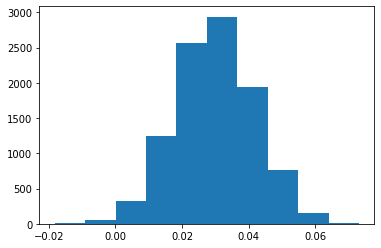

In [87]:
plt.hist(diffs);

In [90]:
np.std(diffs)

0.011833599236660743

* We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.

* $H_0: CTR_n - CRT_o \le 0 $


In [93]:
diffs = np.array(diffs)
null_values = np.random.normal(0, diffs.std(), diffs.size)

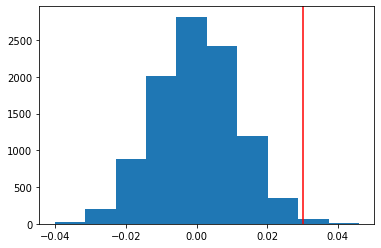

In [94]:
plt.hist(null_values)
plt.axvline(obs_diff, c='r')

In [95]:
(null_values > obs_diff).mean()

0.0059

* We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed differenc

* With a p-value of less than 0.01, it seems unluckly that our statistics is from this null

* Therefore we reject the null hypothesis and Audacity should lunch the new version of the homepage!

**The second change Audacity is A/B testing is** a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course. In this experiment, we’re going to analyze the following metrics:

* Enrollment Rate: Click through rate for the Enroll button the course overview page
* Average Reading Duration: Average number of seconds spent on the course overview page
* Average Classroom Time: Average number of days spent in the classroom for students enrolled in the course
* Completion Rate: Course completion rate for students enrolled in the course

First, let's determine if the difference observed for each metric is statistically significant individually.



##  Metric - Enrollment Rate

In [96]:
cours_df = pd.read_csv('./course_page_actions.csv')
cours_df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [117]:
course_control = cours_df.query('group == "control"')
course_experiment = cours_df.query('group == "experiment"')


In [127]:
course_control.groupby('action').mean()

,id,duration
action,,
enroll,567347.200000,115.495597
view,562673.535335,115.386371


In [130]:
control_ctr = len(course_control.query('action=="enroll"').id.unique()) / len(course_control.query('action=="view"').id.unique())
control_ctr

0.2364438839848676

In [129]:
experiment_ctr = len(course_experiment.query('action=="enroll"').id.unique()) / len(course_experiment.query('action=="view"').id.unique())
experiment_ctr

0.2668693009118541

In [131]:
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030425416926986526

In [133]:
diffs = []
for _ in range(10000):
    bootsample = cours_df.sample(cours_df.shape[0], replace=True)
    course_control = bootsample.query('group == "control"')
    course_experiment = bootsample.query('group == "experiment"')
    control_ctr = len(course_control.query('action=="enroll"').id.unique()) / len(course_control.query('action=="view"').id.unique())
    experiment_ctr = len(course_experiment.query('action=="enroll"').id.unique()) / len(course_experiment.query('action=="view"').id.unique())
    diffs.append(experiment_ctr - control_ctr)


In [134]:
diffs = np.array(diffs)

In [137]:
null_vals = np.random.normal(0, diffs.std(), diffs.shape)

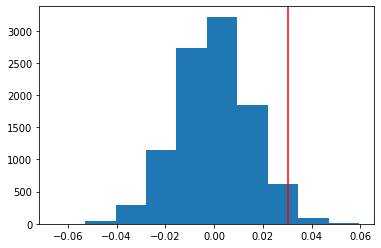

In [140]:
plt.hist(null_vals)
plt.axvline(obs_diff, c='r')

In [139]:
(null_vals > obs_diff).mean()

0.0209

## Metric - Average Reading Duration



In [132]:
cours_df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [97]:
# We are only interested to those who view not click
views = cours_df.query('action=="view"')

In [98]:
reading_time = views.groupby(['id', 'group'])['duration'].mean()


In [99]:
reading_time = reading_time.reset_index()
reading_time.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [102]:
control_mean = cours_df.query('group == "control"')['duration'].mean()
experiment_mean = cours_df.query('group == "experiment"')['duration'].mean()
control_mean, experiment_mean

(115.40710650582041, 130.93220512539474)

In [103]:
obs_diff = experiment_mean - control_mean
obs_diff


15.525098619574337

In [104]:
diffs = []
for _ in range(10000):
    bootsample = cours_df.sample(cours_df.shape[0], replace=True)
    control_mean = bootsample.query('group=="control"' )['duration'].mean()
    experiment_mean = bootsample.query('group=="experiment"' )['duration'].mean()
    diffs.append(experiment_mean-control_mean)

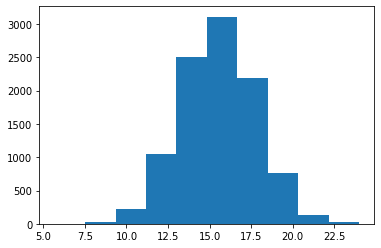

In [105]:
plt.hist(diffs);

In [106]:
diffs = np.array(diffs)

In [108]:
null_vals = np.random.normal(0, diffs.std(), diffs.shape)


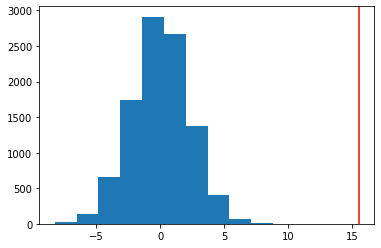

In [109]:
plt.hist(null_vals);
plt.axvline(obs_diff, c='r')

In [111]:
(null_vals > obs_diff).mean()

0.0

* We can see that differences made in the course has a great significance

## Metric - Average Classroom Time

In [114]:
class_df = pd.read_csv('./classroom_actions.csv')
class_df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [141]:
class_control = class_df.query('group == "control"')
class_experiment = class_df.query('group == "experiment"')
class_control.total_days.mean(), class_experiment.total_days.mean()

(73.36899038461539, 74.6715935334873)

In [142]:
obs_diff_c = class_experiment.total_days.mean() - class_control.total_days.mean()
obs_diff_c

1.3026031488719099

In [144]:
diffs_c = []
for _ in range(10000):
    bootsample = class_df.sample(class_df.shape[0], replace=True)
    control_mean = bootsample.query('group=="control"' )['total_days'].mean()
    experiment_mean = bootsample.query('group=="experiment"' )['total_days'].mean()
    diffs_c.append(experiment_mean-control_mean)
    

In [145]:
diffs_c = np.array(diffs_c)

In [146]:
null_vals_c = np.random.normal(0, diffs_c.std(), diffs_c.shape)

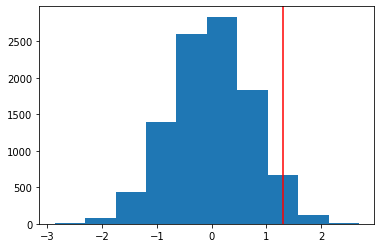

In [147]:
plt.hist(null_vals_c);
plt.axvline(obs_diff_c, c='r')

In [148]:
(null_vals_c > obs_diff_c).mean()

0.038

* Do you have evidence, with a type I error rate of 0.05, that users spend more time in the classroom after seeing the experimental description in the course overview page? **Yes since p-value is less than 0.05**

## Metric - Completion Rate

In [150]:
class_control.completed.mean(), class_experiment.completed.mean()

(0.3719951923076923, 0.3935334872979215)

In [151]:
obs_diff_d =  class_experiment.completed.mean() - class_control.completed.mean()
obs_diff_d

0.02153829499022919

In [152]:
diffs_d = []
for _ in range(10000):
    bootsample = class_df.sample(class_df.shape[0], replace=True)
    control_mean = bootsample.query('group=="control"' )['completed'].mean()
    experiment_mean = bootsample.query('group=="experiment"' )['completed'].mean()
    diffs_d.append(experiment_mean-control_mean)
    

In [153]:
diffs_d = np.array(diffs_d)

In [154]:
null_vals_d = np.random.normal(0, diffs_d.std(), diffs_d.shape)

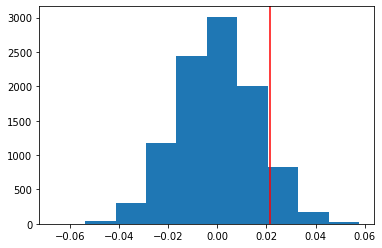

In [155]:
plt.hist(null_vals_d);
plt.axvline(obs_diff_d, c='r')

In [156]:
(null_vals_d > obs_diff_d).mean()

0.0921

* Do you have evidence, with a type I error rate of 0.05, that this course increases in completion rate when using the experimental description on its course overview page? **NO since p-value is 0.092**

## Analyzing Multiple Metrics

* The more metrics you evaluate, the more likely you are to observe significant differences just by chance - similar to what you saw in previous lessons with multiple tests. Luckily, this multiple comparisons problem can be handled in several ways.



* If our original alpha value was 0.05, what would be our new, Bonferroni corrected alpha value? **0.05/4 = 0.0125**

**Let's see which of our metrics produced statistically significant differences based on this new alpha value. Here are the p-values computed for the four metrics in this experiment. (These are the values you should've gotten with a random seed of 42.)**

* Enrollment Rate: 0.0624
* Average Reading Duration: 0
* Average Classroom Time: 0.0384
* Completion Rate: 0.0846

With the Bonferroni corrected alpha value, which of the above metrics produced statistically significant results? **Average Reading Duration**

Since the Bonferroni method is too conservative when we expect correlation among metrics, we can better approach this problem with more sophisticated methods, such as **the closed testing procedure, Boole-Bonferroni bound, and the Holm-Bonferroni method**. These are less conservative and take this correlation into account.

If you do choose to use a less conservative method, just make sure the assumptions of that method are truly met in your situation, and that you're not just trying to cheat on a p-value. Choosing a poorly suited test just to get significant results will only lead to misguided decisions that harm your company's performance in the long run.



## Difficulties in A/B Testing
As you saw in the scenarios above, there are many factors to consider when designing an A/B test and drawing conclusions based on its results. To conclude, here are some common ones to consider.

* Novelty effect and change aversion when existing users first experience a change
* Sufficient traffic and conversions to have significant and repeatable results
* Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
* Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
* Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
* Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)